# Importing Dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
from emoji import demojize
import nltk
nltk.download('stopwords')




[nltk_data] Downloading package stopwords to /home/ahmad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Loading Dataset


In [ ]:
positive_reviews = pd.read_csv('processed_data/pos_data.csv')
negative_reviews = pd.read_csv('processed_data/neg_data.csv')



# Data Exploration

In [3]:
# For Positive Tweets

print("Positive Tweets Shape",positive_reviews.shape)
print("Info of Positive Reviews",positive_reviews.info())
positive_reviews.head()


Positive Tweets Shape (806, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 806 entries, 0 to 805
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  806 non-null    object
 1   content    806 non-null    object
 2   sentiment  806 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 19.0+ KB
Info of Positive Reviews None


,file_name,content,sentiment
0,cv997_5046.txt,"glory--starring matthew broderick , denzel was...",1
1,cv512_15965.txt,it may seem weird to begin a film about glam r...,1
2,cv494_17389.txt,i want to correct what i wrote in a former ret...,1
3,cv626_7410.txt,this reviewer is ignorant of what hands were r...,1
4,cv638_2953.txt,natural born killers is really a very simple s...,1


By analyzing the number of **positive** and **negative** samples, we note that the data is generally balanced (806 positive to 848 negative). Therefore, adopting the *accuracy* measure will give a good impression of the model’s performance.

In [4]:
# For Negative Tweets
print("Negative Tweets Shape",negative_reviews.shape)
print("Info of Negative Tweets",negative_reviews.info())
negative_reviews.head()


Negative Tweets Shape (848, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848 entries, 0 to 847
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  848 non-null    object
 1   content    848 non-null    object
 2   sentiment  848 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 20.0+ KB
Info of Negative Tweets None


,file_name,content,sentiment
0,cv637_13682.txt,i'll bet right now you're just lounging by the...,0
1,cv203_19052.txt,synopsis : sonny koufax ( adam sandler ) is a ...,0
2,cv186_2396.txt,romeo is bleeding wants to carry the unusual f...,0
3,cv489_19046.txt,the u . s . army utilizes a number of books kn...,0
4,cv854_18955.txt,has hollywood run out of interesting character...,0


In [5]:
# Dropping Unecessery filename feature
positive_reviews.drop('file_name',axis=1,inplace=True)
negative_reviews.drop('file_name',axis=1,inplace=True)
positive_reviews.head(5)

,content,sentiment
0,"glory--starring matthew broderick , denzel was...",1
1,it may seem weird to begin a film about glam r...,1
2,i want to correct what i wrote in a former ret...,1
3,this reviewer is ignorant of what hands were r...,1
4,natural born killers is really a very simple s...,1


# Data Splitting & Shuffuling
Care will be taken to initially split the data to prevent data leakage so that all processing and feature extraction functions are applied separately to the training and test data.

In [6]:

def data_split(X,y):
    # Dataset Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return  X_train, X_test, y_train, y_test
stop_words = stopwords.words('english')
# Combine datasets and shuffle
data = pd.concat([positive_reviews, negative_reviews], ignore_index=True)
data = data.sample(frac=1, random_state=42).reset_index(drop=True)  

# Data Preprocessing
Processing here includes removing noise such as unnecessary links and numbers, converting emojis to text, stemming tokens, and filtering stopwords.

In [7]:
# Preprocessing function
def preprocess_text(text):
    # Convert emojis to text
    text = demojize(text)
    # Remove special characters, numbers, and URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^a-zA-Z\s]', '', text) 
    # Lowercase and split into words
    words = text.lower().split()
    # Remove stopwords with Stemming
    stemmer = PorterStemmer()
    filtered_words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(filtered_words)
X = data['content']
y = data['sentiment']
X_train, X_test, y_train, y_test = data_split(X,y)
# Apply preprocessing to content column
X_train = pd.DataFrame(X_train, columns=['content'])
X_train['cleaned_content'] = X_train['content'].apply(preprocess_text)

X_test = pd.DataFrame(X_test, columns=['content'])
X_test['cleaned_content'] = X_test['content'].apply(preprocess_text)


# Feature Engineering

Here, feature extraction processes are applied manually and then a process of adjusting all or some of them as parameters will be followed before feeding them into the model.

In [8]:


# Define the preprocessing and feature extraction function
def extract_features(data):
    features = pd.DataFrame()

    # Punctuation Counts
    features['exclamation_count'] = data.str.count('!')
    features['question_count'] = data.str.count('\?')

    # Text Length Features
    features['char_count'] = data.apply(len)
    features['word_count'] = data.apply(lambda x: len(x.split()))
    features['sentence_count'] = data.apply(lambda x: len(x.split('.')))

    # Average Word Length
    features['avg_word_length'] = data.apply(
        lambda x: sum(len(word) for word in x.split()) / len(x.split()) if len(x.split()) > 0 else 0
    )

    # Stopword Ratio
    features['stopword_ratio'] = data.apply(
        lambda x: len([word for word in x.split() if word in stop_words]) / len(x.split()) if len(x.split()) > 0 else 0
    )



    return features

# Applying Feature Engineering in Dataframe for visualization purposes
custom_features_train = extract_features(X_train['content'])
custom_features_test = extract_features(X_test['content'])


X_train = pd.concat([X_train, custom_features_train], axis=1)
X_test = pd.concat([X_test, custom_features_test], axis=1)


X_train.head()


,content,cleaned_content,exclamation_count,question_count,char_count,word_count,sentence_count,avg_word_length,stopword_ratio
1301,the happy bastard's 30-second review : \nameri...,happi bastard second review american pie summe...,0,1,1455,285,11,4.066667,0.385965
306,i am a steven seagal fan . \ni only say this n...,steven seagal fan say mufti splenetik isnt rea...,1,4,5012,968,41,4.129132,0.370868
192,""" the animal "" is a marginally inspired comedy...",anim margin inspir comedi manag lumber along g...,2,1,3061,590,31,4.138983,0.405085
309,"according to popular film opinion , a film's g...",accord popular film opinion film great determi...,1,2,5020,1054,58,3.709677,0.437381
1168,synopsis : the president of a company wants to...,synopsi presid compani want test selfappoint s...,0,2,3334,634,24,4.222397,0.424290


In [9]:
X_train.describe()

,exclamation_count,question_count,char_count,word_count,sentence_count,avg_word_length,stopword_ratio
count,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000
mean,0.824641,1.917611,3896.697657,747.021164,33.910053,4.176772,0.393998
std,2.053983,3.687902,1762.736714,337.704426,16.357862,0.213527,0.036030
min,0.000000,0.000000,89.000000,17.000000,2.000000,3.576000,0.268698
25%,0.000000,0.000000,2713.500000,519.500000,23.000000,4.036654,0.369477
50%,0.000000,1.000000,3608.000000,692.000000,31.000000,4.163717,0.393629
75%,1.000000,2.000000,4711.500000,906.000000,41.000000,4.307904,0.418528
max,30.000000,70.000000,14955.000000,2678.000000,181.000000,4.962567,0.588235


Here, we notice that several features are strongly correlated, such as the number of words and the number of sentences. This is logical, but the question is which of these will lead to better results individually? Also note the different scalling of features, which will significantly impact the training and performance of models, especially **logistics regression** and **support vector machine**.

In [10]:
X_train.corr(numeric_only=True)

,exclamation_count,question_count,char_count,word_count,sentence_count,avg_word_length,stopword_ratio
exclamation_count,1.000000,0.250837,0.124427,0.148370,0.173133,-0.249054,-0.001905
question_count,0.250837,1.000000,0.216424,0.239047,0.208551,-0.209562,0.065440
char_count,0.124427,0.216424,1.000000,0.995794,0.789369,0.060365,0.150858
word_count,0.148370,0.239047,0.995794,1.000000,0.807414,-0.022430,0.183681
sentence_count,0.173133,0.208551,0.789369,0.807414,1.000000,-0.172608,0.176207
avg_word_length,-0.249054,-0.209562,0.060365,-0.022430,-0.172608,1.000000,-0.381294
stopword_ratio,-0.001905,0.065440,0.150858,0.183681,0.176207,-0.381294,1.000000


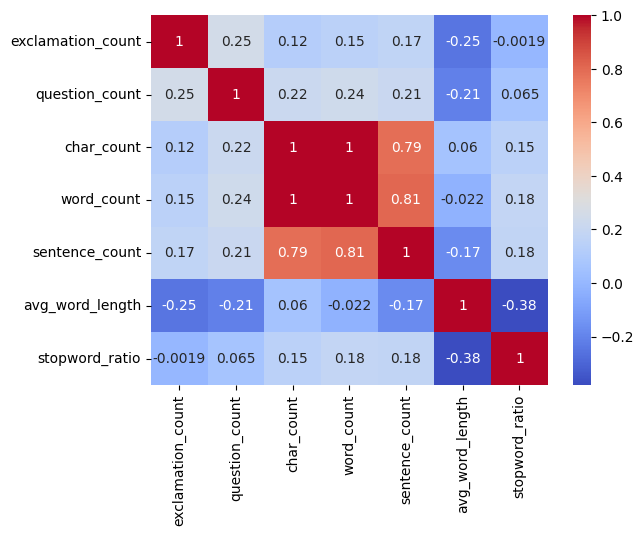

In [11]:
# Plotting correlation matrix
corr_matrix = X_train.corr(numeric_only=True)
sns.heatmap(data=corr_matrix,annot=True,cmap='coolwarm')
plt.show()

The number of characters, the number of words, the number of sentences, are all features that are logically related to each other, so adding them all in the training process will lead to very poor results in generalization, ***not to mention that they are in different scalling ranges.***

# TF-IDF Vectoraization
Here, a vectorizer is used. In fact, the hyperparameter that played a pivotal role in the model's performance was the maximum number of features, which is logical because most learning models are prone to overfitting due to the curse of dimensionality. Therefore, adjusting the number of dimensions to be used in the model had a very strong impact. The hyperparameter value tuned from ***50,000 to 1,500 *** and the models' performance improved significantly when we reached the limits between ***2,500 and 1,500.***

In [ ]:
def tfidf_vectorize(train,test,allow_feature_extraction,features_to_allow = ['exclamation_count', 'char_count', 'word_count', 'question_count','sentence_count', 'avg_word_length' ,'stopword_ratio']):

    tfidf_vectorizer = TfidfVectorizer(
        max_features=2500    ,       
        max_df=0.95,                # Remove words that appear too frequently
        min_df=7,                 # Remove words that appear in fewer than 5 docs
        ngram_range=(1, 4),       # Use both unigrams and bigrams
        stop_words=stop_words     # Pass stopwords directly
    )
   
    X_train_tfidf = tfidf_vectorizer.fit_transform(train['cleaned_content'])
    X_test_tfidf = tfidf_vectorizer.transform(test['cleaned_content'])

    if allow_feature_extraction:
        custom_features_train = train[features_to_allow].values
        custom_features_test =  test[features_to_allow].values
        from scipy.sparse import hstack
        X_train_combined =hstack([X_train_tfidf, custom_features_train])
        X_test_combined = hstack([X_test_tfidf, custom_features_test])
        
        return X_train_combined, X_test_combined
    else:
        return X_train_tfidf,X_test_tfidf

 After a careful examination of the effect of all features (which will be discussed later in the summary of the performance of the experiments), it turns out that features such as the question marks count and the exclamation mark count are the two most valuable features (or the features that did not negatively affect the model's performance), simply because they play a role in determining the sentence state of the person, even at the grammatical level.

In [13]:
# all extracted features :  ['exclamation_count', 'char_count', 'word_count', 'question_count','sentence_count', 'avg_word_length' ,'stopword_ratio']
features_to_allow =['exclamation_count',  'question_count' ]
X_train_combined ,X_test_combined= tfidf_vectorize(X_train,X_test,allow_feature_extraction=True,features_to_allow=features_to_allow )


# Model Training

Here, many models were trained with shallow tuning of the underlying hyperparameters of each model. The **SVMs** were very sensitive to changes in the margin parameter (C parameter) due to their strong sensitivity to scaling.

In [14]:
model = XGBClassifier(n_estimators=50,max_depth=10)
model.fit(X_train_combined, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

# Model Evaluation

In [ ]:

y_pred = model.predict(X_test_combined)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Perform cross validation
cross_val_scores = cross_val_score(model, X_train_combined, y, cv=10)  
print(f"15-Fold Cross-Validation Mean Accuracy: {cross_val_scores.mean():.2f}")

# Check for overfitting
train_accuracy = model.score(X_train_combined, y_train)
test_accuracy = model.score(X_test_combined, y_test)
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.82      0.81       175
           1       0.79      0.76      0.78       156

    accuracy                           0.79       331
   macro avg       0.79      0.79      0.79       331
weighted avg       0.79      0.79      0.79       331

Training Accuracy: 1.00
Testing Accuracy: 0.79


| **Model**             | **Hyperparams**                  | **Features**                                | **TF-IDF Settings**                              | **Prec (0/1)** | **Rec (0/1)** | **F1 (0/1)** | **Acc** | **Train Acc** | **Test Acc** | **15-Fold CV** | **Notes**                           |
|-----------------------|----------------------------------|---------------------------------------------|--------------------------------------------------|----------------|---------------|--------------|---------|---------------|--------------|----------------|-------------------------------------|
| **LogReg**           | `C=1, solver='lbfgs'`           | False                                        | `max_f=2500, max_df=0.95, min_df=10, ngr=(1,4)`                                      | 0.85/0.83     | 0.85/0.83    | 0.85/0.83   | 0.84    | 0.96          | 0.84         | 0.84           | Baseline, slight overfit            |
| **LogReg**           | `C=1, solver='lbfgs'`           | `excl, char, word, sent, avg_w, stop_r`     | `max_f=2500, max_df=0.95, min_df=10, ngr=(1,4)`                             | 0.78/0.80     | 0.83/0.73    | 0.80/0.76   | 0.79    | 0.89          | 0.79         | 0.84           | Too many feats hurt perf            |
| **LogReg**           | `C=1, solver='lbfgs'`           | `excl, sent, avg_w, stop_r`                 | `max_f=2500, max_df=0.95, min_df=10, ngr=(1,4)` | 0.80/0.77     | 0.79/0.78    | 0.80/0.78   | 0.79    | 0.88          | 0.79         | 0.80           | Reduced feats, below baseline       |
| **LogReg**           | `C=1, solver='lbfgs'`           | `excl, sent, avg_w, stop_r`                 | `max_f=500, max_df=0.95, min_df=10, ngr=(1,4)`  | 0.83/0.83     | 0.85/0.80    | 0.84/0.81   | 0.83    | 0.95          | 0.83         | 0.84           | Low `max_f` nears baseline          |
| **LogReg**           | `C=1, solver='lbfgs'`           | `excl, quest, avg_w`                        | `max_f=500, max_df=0.95, min_df=10, ngr=(1,4)`                                   | 0.79/0.77     | 0.79/0.76    | 0.79/0.77   | 0.78    | 0.87          | 0.78         | -              | Selective feats, decent             |
| **LogReg**           | `C=1, solver='lbfgs'`           | `excl, quest`                               | `max_f=500, max_df=0.95, min_df=10, ngr=(1,4)`                                    | 0.82/0.79     | 0.81/0.80    | 0.82/0.80   | 0.81    | 0.88          | 0.81         | -              | No `avg_w` boosts perf              |
| **RandForest**       | `n_est=200`                     | `excl, sent, avg_w, stop_r`                 | `max_f=2500, max_df=0.85, min_df=7, ngr=(1,3)`  | 0.82/0.79     | 0.81/0.80    | 0.82/0.80   | 0.81    | 1.00          | 0.81         | 0.82           | High time, overfits (train=1)       |
| **XGBoost**          | Default                         | `excl, sent, avg_w, stop_r`                 | `max_f=2500, max_df=0.85, min_df=7, ngr=(1,3)`  | 0.82/0.79     | 0.81/0.80    | 0.82/0.80   | 0.81    | 1.00          | 0.81         | -              | Overfits heavily (train=1)          |
| **SVC**              | Default                         | `excl, sent, avg_w, stop_r`                 | `max_f=2500, max_df=0.85, min_df=7, ngr=(1,3)`  | 0.55/0.49     | 0.54/0.50    | 0.55/0.50   | 0.52    | 0.55          | 0.52         | -              | Near random guessing                |
| **SVC**              | Default                         | `excl, char, word, sent, avg_w, stop_r`     | `max_f=2500, max_df=0.95, min_df=10, ngr=(1,4)` | 0.55/0.53     | 0.74/0.33    | 0.63/0.41   | 0.55    | 0.57          | 0.55         | -              | Poor, slight improvement            |
| **SVC**              | `C=0.3`                         | False                                        | `max_f=2500, max_df=0.95, min_df=10, ngr=(1,4)`                                   | 0.80/0.85     | 0.88/0.76    | 0.84/0.80   | 0.82    | 0.96          | 0.82         | -              | No feats, good but slight overfit   |
| **SVC**              | `C=0.3`                         | `excl, char, word, sent, avg_w, stop_r`     | `max_f=2500, max_df=0.95, min_df=10, ngr=(1,4)`                                   | 0.55/0.53     | 0.74/0.32    | 0.63/0.40   | 0.54    | 0.57          | 0.54         | -              | All feats degrade perf              |
| **DecTree**          | Default                         | `excl, char, word, sent, avg_w, stop_r`     | `max_f=2500, max_df=0.95, min_df=10, ngr=(1,4)` | 0.61/0.56     | 0.59/0.58    | 0.60/0.57   | 0.58    | 1.00          | 0.58         | -              | Severe overfit (train=1)            |
| **NaiveBayes**       | Default                         | `excl, char, word, sent, avg_w, stop_r`     | `max_f=2500, max_df=0.95, min_df=10, ngr=(1,4)` | 0.73/0.64     | 0.62/0.75    | 0.67/0.69   | 0.68    | 0.75          | 0.68         | -              | Mild overfit, moderate perf         |
| **NaiveBayes**       | Default                         | False                                        | `max_f=2500, max_df=0.95, min_df=10, ngr=(1,4)` | 0.82/0.85     | 0.87/0.78    | 0.85/0.81   | 0.83    | 0.91          | 0.83         | -              | No feats, strong perf               |
| **NaiveBayes**       | Default                         | False                                        | `max_f=1500, max_df=0.95, min_df=10, ngr=(1,4)` | 0.81/0.81     | 0.83/0.78    | 0.82/0.79   | 0.81    | 0.89          | 0.81         | -              | Low `max_f` dips perf               |
| **NaiveBayes**       | Default                         | False                                        | `max_f=2000, max_df=0.9, min_df=8, ngr=(1,3)`   | 0.84/0.82     | 0.85/0.81    | 0.84/0.82   | 0.83    | 0.90          | 0.83         | -              | Balanced, strong perf               |
| **NaiveBayes**       | Default                         | False                                        | `max_f=1750, max_df=0.85, min_df=7, ngr=(1,3)`  | 0.81/0.83     | 0.86/0.78    | 0.83/0.80   | 0.82    | 0.90          | 0.82         | -              | Slightly below `max_f=2000`         |





## Conclusion

### Logistic Regression
Logistic Regression performs best with minimal or no additional custom features, achieving a test accuracy of 0.84. However, adding features such as the number of letters, words, sentences, question marks, and exclamation marks negatively impacts performance, reducing accuracy to 0.79 due to feature correlation and the introduction of noise. This is exacerbated by the lack of feature scaling. Using selective feature engineering, such as limiting features to 500 via TF-IDF and including counts of question and exclamation marks, improves results slightly to an accuracy of 0.81, balancing training and testing accuracy while reducing overfitting. For the regularization parameter C, lower values (e.g., below the default of 1) decrease test accuracy, indicating sensitivity to parameter tuning.

### Decision Trees
Decision Trees are inherently prone to overfitting, with a training accuracy of 1.00 and a test accuracy of only 0.58. This makes them unsuitable for this dataset without significant adjustments, as they fail to generalize well.

### Random Forest and XGBoost
Random Forest and XGBoost offer potential solutions to the overfitting issues of standalone Decision Trees but come with their own challenges. Both models achieve a training accuracy of 1.00 and a test accuracy of 0.81, indicating severe overfitting despite their complexity. Using a highly complex model with increased feature complexity (e.g., TF-IDF Vectorizer) worsens performance. Random Forest has a longer training time compared to XGBoost, which is itself a more intricate model. In my opinion, the data benefits more from simpler models rather than these computationally intensive approaches.

### SVC (Support Vector Classifier)
The Support Vector Classifier (SVC) with default settings underfits when manually extracted features are included, yielding poor accuracy between 0.52 and 0.55. However, tuning the model, such as reducing the C parameter to 0.3 and disabling custom features, improves performance to an accuracy of 0.82. Despite this improvement, slight overfitting persists, with a difference between training and testing accuracy exceeding 0.1. This sensitivity to noise from additional features and the lack of scaling limits its robustness compared to simpler alternatives.

### Naive Bayes
The Naive Bayes model stands out as the most stable and efficient option. It requires no training time and delivers strong performance, achieving a test accuracy of 0.83 with optimized TF-IDF settings (feature limits between 1,500 and 2,000). However, it is highly sensitive to new features; adding custom features significantly reduces its accuracy to 0.68. Its simplicity and effectiveness make it the strongest performer overall when features are kept minimal.